<a href="https://colab.research.google.com/github/uc2045/genai-projects/blob/master/Dec2024_Multimodal_RAG_System_with_GPT_4o_DJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG System

Many documents contain a mixture of content types, including text, tables and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4o](https://openai.com/index/hello-gpt-4o/), it is worth considering how to utilize images in RAG Systems:

![](https://i.imgur.com/5BpuocV.png)


---

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/index/hello-gpt-4o/), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images and tables
* Embed and retrieve image, table and text summaries with a reference to the raw images and tables
* Pass raw images, tables and text chunks to a multimodal LLM for answer synthesis   

---



* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) and Redis to store raw text and images along with their summaries for retrieval.
* We will use GPT-4o for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).


___Created By: [Dipanjan (DJ)](https://www.linkedin.com/in/dipanjans/)___



In [ ]:
!pip install langchain==0.3.12
!pip install langchain-openai==0.2.12
!pip install langchain-chroma==0.1.4
!pip install langchain-community==0.3.12
!pip install redis==5.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.8
    Uninstalling langsmith-0.3.8:
      Successfully uninstalled langsmith-0.3.8
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.18
    Uninstalling langchain-0.3.18:
      Successfully uninstalled langchain-0.3.18
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.3 M

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
# older stable version 0.15.5
!pip install "unstructured[all-docs]==0.16.10"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 32.6 MB/s eta 0:

In [ ]:
# install OCR dependencies for unstructured
!sudo apt-get install tesseract-ocr
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,712 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
!pip install htmltabletomd

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for htmltabletomd: filename=htmltabletomd-1.0.0-py2.py3-none-any.whl size=3577 sha256=c30595d51aaac668cb3c8af0b34fecca671596d4e43aea674aaee1257f906acb
  Stored in directory: /root/.cache/pip/wheels/8e/ef/53/7288ca33eab4211fc5bc4febafe7e5552ba5bbaf8dd1839669
  Created wheel for html2markdown: filename=html2markdown-0.1.7-py3-none-any.whl size=5234 sha256=15738689cbdbc6ab08b6005cbdad6c161ef71754269999ba1c320b2980ea264d
  Stored in directory: /root/.cache/pip/wheels/fa/63/7b/e898c8d7cbb84d2538052c56fd849bfb43a472c1824acd2ef7
Successfully built htmltabletomd html2markdown


## Data Loading

### Partition PDF tables, text, and images
  

In [ ]:
!wget https://sgp.fas.org/crs/misc/IF10244.pdf

--2025-02-15 12:41:27--  https://sgp.fas.org/crs/misc/IF10244.pdf
Resolving sgp.fas.org (sgp.fas.org)... 18.65.3.58, 18.65.3.95, 18.65.3.31, ...
Connecting to sgp.fas.org (sgp.fas.org)|18.65.3.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435826 (426K) [application/pdf]
Saving to: ‘IF10244.pdf’

IF10244.pdf         100%[===================>] 425.61K   752KB/s    in 0.6s    

2025-02-15 12:41:29 (752 KB/s) - ‘IF10244.pdf’ saved [435826/435826]



In [ ]:
!rm -rf ./figures

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

doc = './IF10244.pdf'

# takes 1 min on Colab
loader = UnstructuredPDFLoader(file_path=doc,
                               strategy='hi_res',
                               extract_images_in_pdf=True,
                               infer_table_structure=True,
                               chunking_strategy="by_title", # section-based chunking
                               max_characters=4000, # max size of chunks
                               new_after_n_chars=4000, # preferred size of chunks
                               combine_text_under_n_chars=2000, # smaller chunks < 2000 chars will be combined into a larger chunk
                               mode='elements',
                               image_output_dir_path='./figures')
data = loader.load()

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
len(data)

7

In [ ]:
[doc.metadata['category'] for doc in data]

['CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement']

In [ ]:
data[0]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T01:27:48', 'page_number': 1, 'orig_elements': 'eJzFWG1v3DYS/ivEAgfYwFIlKUoiDdwH14EBF7i0qFP0QxIYlETtstVKgl6cbIv77zdDam157RYXA+vmg2OOyOG8cZ5n/PHPla3tzjbjnStXF2QlOat0VpVUVDanUqWaGi4lVXmutbCsqKRerclqZ0dTmtHAmT9XRdv2pWvMaAe/rs2+nca7rXWb7QgSIRiDM7P4iyvHLUh55qVd65oRz338yFMWgYhH+vOaHFYiyaLUr5NYR9kLAtwP69WwH0a7Qy9+cl9tfduZwq7+Cx8qV9tx31n/6af/oP1uZzb2rjPektV3RduMEITvKreZejvM/1NOefRbt1l545vNBGe8pSvbbFafvXQY73Zt6SpnffwEE5IySTn7wPiFyC6kwtMd3tZMu9z26DkaNdqvGJuViYgx5N/kpqnafueaDRm3ltR244bajO7ektLmEFoyuKawhGsuyVXbbMDMwbWNqcnPdrCmL7bk1vb3DnxG7bO7N+gnBuE40cLKImW8oqZMFJVFnlCthKaxFamNEyFVnJ0u0UJnUYKp1BHzqTwINDvkVopIviTwR/423aUdbTFCbO4KyM9w1/VtDttYBPWi05fr4WTp/aWD6NmS/DA1kDywn4l4maD3pu99mj/ggZcSxZVJbKLh2oxRqcuEKqUFjU0W2zRPq5KLU79IoeNILN5kLFVYJzLBF3i8DvtflySViDR74yT96uqycr0ltyPkYhhdMSxz9MGN9YuPKC+ZKbXMaJxwQWWiDM2rCpaWK5XmcZlnJ3xEcy4Ui7JFbhRLIolrFcsofr4O+1+XG51A+/mHcjMQAwmamg5uauBBe

In [ ]:
data[2]

Document(metadata={'source': './IF10244.pdf', 'last_modified': '2024-04-10T01:27:48', 'text_as_html': '<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.

In [ ]:
from IPython.display import HTML, display, Markdown


In [ ]:
print(data[2].page_content)

2018 2019 2020 Number of Fires (thousands) Federal 12.5 10.9 14.4 FS 5.6 5.3 6.7 DOI 7.0 5.3 7.6 2021 14.0 6.2 7.6 11.7 5.9 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6


In [ ]:
data[2].metadata['text_as_html']

'<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><

In [ ]:
display(Markdown(data[2].metadata['text_as_html']))

<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td></tr><tr><td>Nonfederal</td><td>4.1</td><td>1.6</td><td>3.1</td><td>Lg</td><td>3.6</td></tr><tr><td>Total</td><td>8.8</td><td>4.7</td><td>10.1</td><td>7.1</td><td>7.6</td></tr></table>

Since unstructured extracts the text from the table without any borders, we can use the HTML text and put it directly in prompts (LLMs understand HTML tables well) or even better convert HTML tables to Markdown tables as below

In [ ]:
import htmltabletomd

md_table = htmltabletomd.convert_table(data[2].metadata['text_as_html'])
print(md_table)

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |



In [ ]:
md_table

'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |\n| FS | 2.3 | 0.6 | 48 | 41 | 19 |\n| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |\n| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |\n'

In [ ]:
docs = []
tables = []

for doc in data:
    if doc.metadata['category'] == 'Table':
        tables.append(doc)
    elif doc.metadata['category'] == 'CompositeElement':
        docs.append(doc)

len(docs), len(tables)

(5, 2)

In [ ]:
for table in tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

In [ ]:
for table in tables:
    print(table.page_content)
    print()

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|  | 2019 | 2020 | 2021 | 2022 |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |




In [ ]:
! ls -l ./figures

total 144
-rw-r--r-- 1 root root 27929 Feb 15 12:46 figure-1-1.jpg
-rw-r--r-- 1 root root 27182 Feb 15 12:46 figure-1-2.jpg
-rw-r--r-- 1 root root 26589 Feb 15 12:46 figure-1-3.jpg
-rw-r--r-- 1 root root 26448 Feb 15 12:46 figure-2-4.jpg
-rw-r--r-- 1 root root 29260 Feb 15 12:46 figure-2-5.jpg


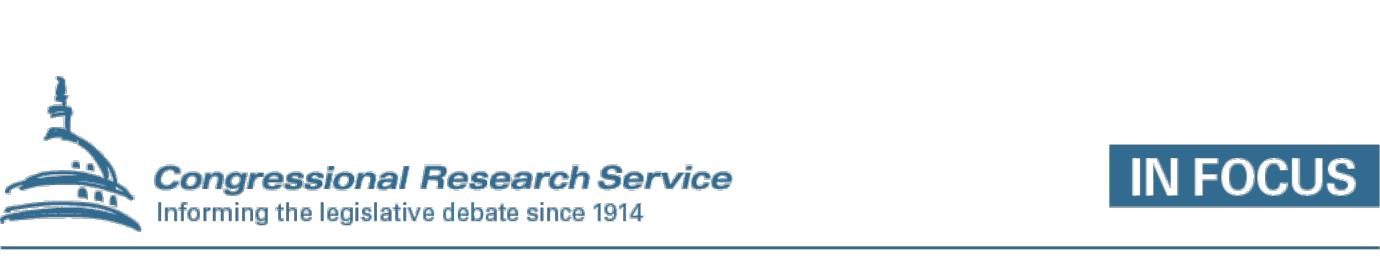

In [ ]:
from IPython.display import Image

Image('./figures/figure-1-1.jpg')

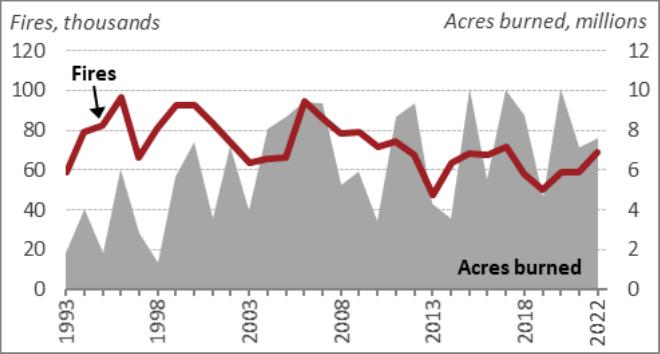

In [ ]:
Image('./figures/figure-1-2.jpg')

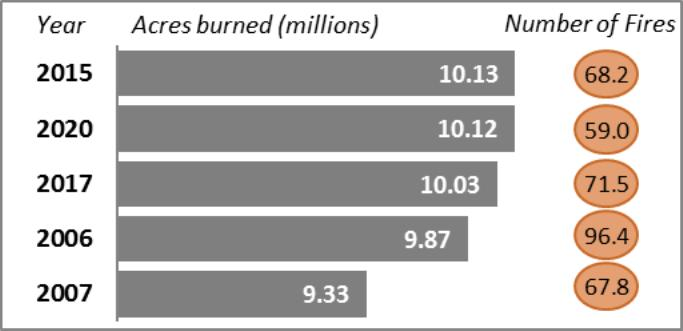

In [ ]:
Image('./figures/figure-1-3.jpg')

#### Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

#### Load Connection to LLM

Here we create a connection to ChatGPT to use later in our chains

In [ ]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4o to produce table and, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Also follow the following rules:

Do not add words or phrases like:
  - This Summary
  - This Document
  - This Table etc.

Just output the actual description.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    chatgpt
                      |
                    StrOutputParser() # extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 5})

len(text_summaries), len(table_summaries)

(5, 2)

In [ ]:
text_summaries[0]

'Wildfire statistics provide insights into U.S. wildfire activity, highlighting trends and responsibilities in wildfire management. Wildfires, which can be caused by natural events like lightning or human activities, are managed by states on nonfederal lands and by federal agencies on federal lands. The Forest Service manages wildfires across 193 million acres of the National Forest System, while the Department of the Interior oversees over 400 million acres of national parks, wildlife refuges, and other public lands. Data from the National Interagency Coordination Center (NICC) shows that while the number of wildfires has slightly decreased over the past 30 years, the acreage burned has generally increased. From 2000 to 2022, an average of 70,025 wildfires burned 7.0 million acres annually, more than double the average acreage burned in the 1990s. Between 2013 and 2022, there were an average of 61,410 wildfires annually, affecting 7.2 million acres. In 2022, 68,988 wildfires burned 7.

In [ ]:
table_summaries[0]

'The table provides data on the number of fires and acres burned in the United States from 2018 to 2022, categorized by federal and nonfederal sources. \n\nFor the number of fires (in thousands), federal fires fluctuated, peaking at 14.4 thousand in 2020 and dropping to 11.7 thousand in 2022. The Forest Service (FS) reported a significant increase in 2022 with 59 thousand fires. The Department of the Interior (Dol) saw a peak in 2020 with 7.6 thousand fires. Nonfederal fires remained relatively stable, with a slight increase in 2022 to 7.2 thousand. The total number of fires peaked in 2022 at 69.0 thousand.\n\nFor acres burned (in millions), federal acres burned peaked in 2020 at 7.1 million and saw a dramatic increase in 2022 to 40 million. The FS reported a significant increase in 2020 with 48 million acres burned. Nonfederal acres burned peaked in 2020 at 3.1 million, with a notable entry of "Lg" in 2021. The total acres burned peaked in 2020 at 10.1 million.'

### Image summaries

We will use [GPT-4o](https://openai.com/index/hello-gpt-4o/) to produce the image summaries.

* We pass base64 encoded images

In [ ]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", temperature=0)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary description of the image that is well optimized for retrieval.
                Also follow the following rules:

                Do not add words or phrases like:
                    - This Summary
                    - This Image
                    - This Figure etc.

                Just output the actual description.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

In [ ]:
len(imgs_base64), len(image_summaries)

(5, 5)

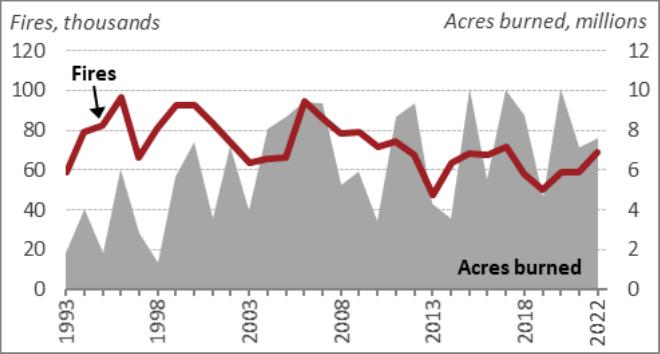

In [ ]:
display(Image('./figures/figure-1-2.jpg'))

In [ ]:
image_summaries[1]

'Line and area chart depicting the number of fires and acres burned in the United States from 1993 to 2022. The left y-axis represents the number of fires in thousands, while the right y-axis shows acres burned in millions. The x-axis displays years from 1993 to 2022. A red line indicates the number of fires, peaking around 1996 and 2006, with fluctuations throughout the period. A gray shaded area represents acres burned, with notable peaks around 2006, 2012, and 2020. The chart highlights trends in fire occurrences and the extent of land affected over nearly three decades.'

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore` (here we are using Redis).
* Store the texts, table summaries, and image summaries in the `vectorstore` (here we are using Chroma) for efficient semantic retrieval.

In [ ]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [ ]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [ ]:
docs[0]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T01:27:48', 'page_number': 1, 'orig_elements': 'eJzFWG1v4zYS/iuEgQMSwFJJkZKoAPchzSJACty2aLboh91FQJGUzVaWBL1k1y3uv98MKSeKkxa3AZzmg2OOxOG8cZ5n/PHPla3tzjbjnTOrC7ISVaIzkxeRSuBDpBmPpE5kJExqdUUzzliyWpPVzo7KqFHBnj9Xum174xo12sGva7Vvp/Fua91mO4IkSSiFPbP4izPjFqQs99Kudc2I+z5+ZBmNQcTi4vOaHFZJmseZX6e8iPMXBPg+rFfDfhjtDr34yX219W2ntF39Fx5UrrbjvrP+0U//QfvdTm3sXae8JavvdNuMEITvKreZejvM/yMWsfi3brPyxjebCfZ4S1e22aw+e+kw3u1a4ypnffwSmoiIiojRD5RdJPmFkLi7w9OaaVfaHj1Ho0b7FWOzUjFRivyb3DRV2+9csyHj1pLabtxQq9HdW2JsCaElg2u0Jaxggly1zQbMHFzbqJr8bAerer0lt7a/d+Azap/dvUE/MQjHiZbMKKq4iFJbikhkNo8kzUyks6oUUuVW8ux0iU6KPE4xlUVMfSoPgoIeciuSWLwk8Fv+Nt3GjlaPEJs7DfkZ7rq+LeE1GkO9FNnL9XCy9P7SQfSsIT9MDSQP7KcJXybovep7n+YPuOGFRKWaJyrJsihP0iQSPGeRkkZHPNOloqlRhU1PfSOTgsfJ4k5yIcM6FSnewON1eP91SZJpkuVvnKRfXW0q11tyO0IuhtHpYZmjD26sX7xEVVZaw3UeFaWxkchZERWWc8gS1K218CHoqXPDJY3zRW4kTWOBa8lFzJ+vw/uvy02RQvv5h3IzEAUJmpoOTmrgQ

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """


    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries and their embeddings
chroma_db = Chroma(
    collection_name="mm_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

# Initialize the storage layer - to store raw images, text and tables
client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client) # you can use filestore, memorystory, any other DB store also

# Create retriever
retriever_multi_vector = create_multi_vector_retriever(
    redis_store,
    chroma_db,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

In [ ]:
retriever_multi_vector

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x79f1c490d2d0>, docstore=<langchain_community.storage.redis.RedisStore object at 0x79f1c490d4b0>, search_kwargs={})

## Multimodal RAG



In [ ]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

### Check Retrieval

Examine retrieval; we get back images and tables also that are relevant to our question.

In [ ]:
# Check retrieval
query = "Analyze the trend of annual wildfires with acres burned over the years"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [ ]:
docs

[b'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
 b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mj

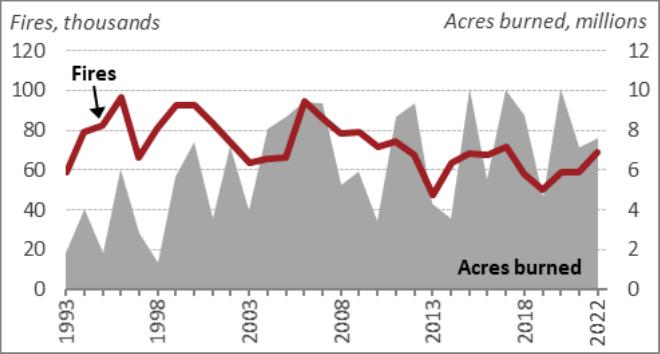

In [ ]:
plt_img_base64(docs[3])

In [ ]:
# Check retrieval
query = "Tell me about the percentage of residences burned by wildfires in 2022"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [ ]:
docs

[b'| | | | | |\n| :--- | :--- | :--- | :--- | :--- |\n|  | 2019 | 2020 | 2021 | 2022 |\n| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |\n| % Residences | 46% | 54% | 60% | 46% |\n',
 b'Source: National Interagency Coordination Center (NICC)\n\n2022\n\nYear Acres burned (millions) Number of Fires 2015 2020 2017 2006 2007\n\nSource: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.\n\nThe number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire\xe2\x80\x99s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.\n\nMost wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn mo

### Utilities to separate retrieved elements

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

Here we need to have text, table elements as one set of inputs and image elements as the other set of inputs as both require separate prompts in GPT-4o.

In [ ]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content.decode('utf-8')
        else:
            doc = doc.decode('utf-8')
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

In [ ]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

4

In [ ]:
docs

[b'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
 b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mj

In [ ]:
is_image_data(docs[1].decode('utf-8'))

True

In [ ]:
r = split_image_text_types(docs)
r

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiyn/XV/wCddNQBzP8Awgeif3J/+/po/wCED0T+5P8A9/TXTUUAcz/wgeif3J/+/po/4QPRP7k//f010rMqKWdgqjqScAUKysoZWBU8gg8UAc1

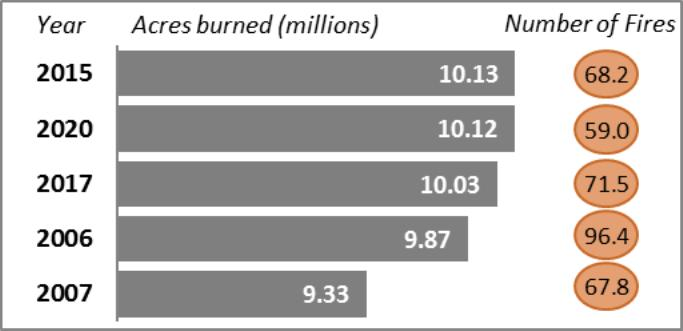

In [ ]:
plt_img_base64(docs[1].decode('utf-8'))

## Multimodal RAG

### Build End-to-End Multimodal RAG Pipeline

Now let's connect our retriever, prompt instructions and build a multimodal RAG chain

In [ ]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends from text documents,
                data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


# Create RAG chain
multimodal_rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        chatgpt
            |
        StrOutputParser()
)

# Pass input query to retriever and get context document elements
retrieve_docs = (itemgetter('input')
                    |
                retriever_multi_vector
                    |
                RunnableLambda(split_image_text_types))

# Below, we chain `.assign` calls. This takes a dict and successively
# adds keys-- "context" and "answer"-- where the value for each key
# is determined by a Runnable (function or chain executing at runtime).
# This helps in also having the retrieved context along with the answer generated by GPT-4o
multimodal_rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                               .assign(answer=multimodal_rag)
)

In [ ]:
# Run RAG chain
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
response = multimodal_rag_w_sources.invoke({'input': query})
response

{'input': 'Tell me detailed statistics of the top 5 years with largest wildfire acres burned',
 'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiy

In [ ]:
def multimodal_rag_qa(query):
    response = multimodal_rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

Answer:


The top five years with the largest wildfire acreage burned since 1960 are as follows:

1. **2015**
   - Acres burned: 10.13 million
   - Number of fires: 68,200

2. **2020**
   - Acres burned: 10.12 million
   - Number of fires: 59,000

3. **2017**
   - Acres burned: 10.03 million
   - Number of fires: 71,500

4. **2006**
   - Acres burned: 9.87 million
   - Number of fires: 96,400

5. **2007**
   - Acres burned: 9.33 million
   - Number of fires: 67,800

These statistics highlight the years with the most significant wildfire activity in terms of acreage burned.

----------------------------------------------------------------------------------------------------
Sources:


Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960

Table 1. Annual Wildfires and Acres Burned

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% __ Non- federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2020 2021 2022

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

Figure 4. Acreage Burned by Region and Ownership

Acres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal ON FD Ww 2018 2022 2019 2020 2021

a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Acres burned, millions Fires, thousands 120 Fires 100 \

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

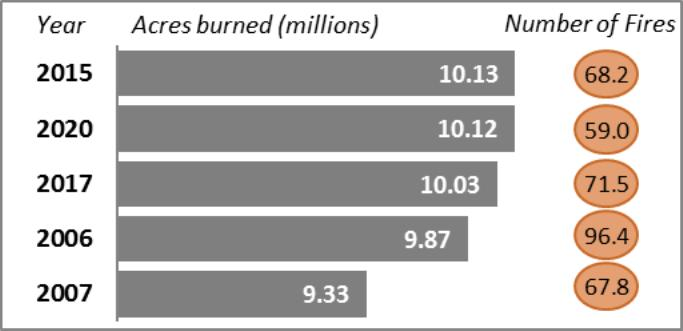

In [ ]:
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
multimodal_rag_qa(query)

Answer:


The analysis of the trend of annual wildfires and acres burned over the years reveals several key points:

1. **Number of Wildfires**:
   - The number of annual wildfires has shown variability but has generally decreased slightly over the last 30 years.
   - In the 1990s, there was an average of 78,600 wildfires annually.
   - From 2013 to 2022, the average number of wildfires decreased to 61,410 annually.
   - In 2022, there were 68,988 wildfires.

2. **Acres Burned**:
   - The number of acres burned annually has generally increased over the years.
   - In the 1990s, the average annual acreage burned was 3.3 million acres.
   - Since 2000, the average annual acreage burned has more than doubled to 7.0 million acres.
   - From 2013 to 2022, the average annual acreage burned was 7.2 million acres.
   - In 2022, 7.6 million acres were burned, with over 40% of those acres in Alaska.

3. **Top Years for Acreage Burned**:
   - The top five years with the largest wildfire acreage burned since 1960 include 2015, 2020, 2017, 2006, and 2007, with over 9 million acres burned each year.
   - 2015 had the highest acreage burned at 10.13 million acres.

4. **Recent Trends**:
   - As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres.

Overall, while the number of wildfires has decreased slightly, the acreage burned has increased significantly, indicating that wildfires are becoming larger and potentially more severe.

----------------------------------------------------------------------------------------------------
Sources:


Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960

Table 1. Annual Wildfires and Acres Burned

a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Acres burned, millions Fires, thousands 120 Fires 100 \

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

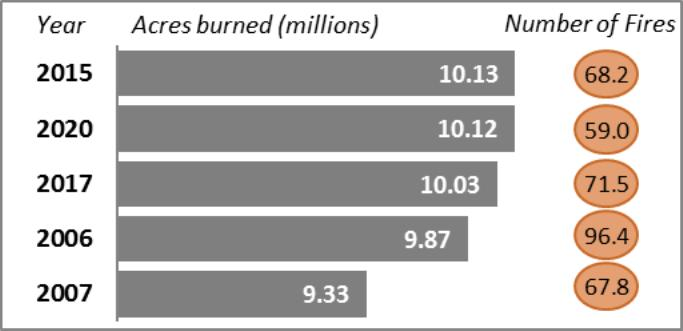

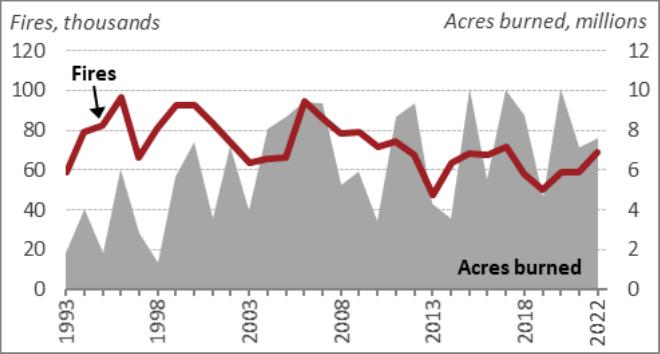

In [ ]:
# Run RAG chain
query = "Analyze the trend of annual wildfires with acres burned over the years"
multimodal_rag_qa(query)

In [ ]:
# Run RAG chain
query = "Tell me about the percentage of residences burned by wildfires in 2022"
multimodal_rag_qa(query)

Answer:


In 2022, 46% of the structures burned by wildfires were residences. A total of 2,717 structures were burned that year. This information is sourced from the National Interagency Coordination Center (NICC).

----------------------------------------------------------------------------------------------------
Sources:


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|  | 2019 | 2020 | 2021 | 2022 |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |


Source: National Interagency Coordination Center (NICC)

2022

Year Acres burned (millions) Number of Fires 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% __ Non- federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2020 2021 2022

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

Figure 4. Acreage Burned by Region and Ownership

Acres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal ON FD Ww 2018 2022 2019 2020 2021

a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Acres burned, millions Fires, thousands 120 Fires 100 \

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.